<a href="https://colab.research.google.com/github/puspitalaras/binar-challenge-API-Platinum-Kelompok-3/blob/main/Copy_of_LSTM_PLATINUM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/BINAR DSC18-3/train_preprocess.tsv.txt', sep='	', header=None, names=['teks', 'label'])
df.shape

(11000, 2)

In [ ]:
df.label.value_counts()

label
positive    6416
negative    3436
neutral     1148
Name: count, dtype: int64

In [ ]:
df.head()

,teks,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


array([<Axes: ylabel='count'>], dtype=object)

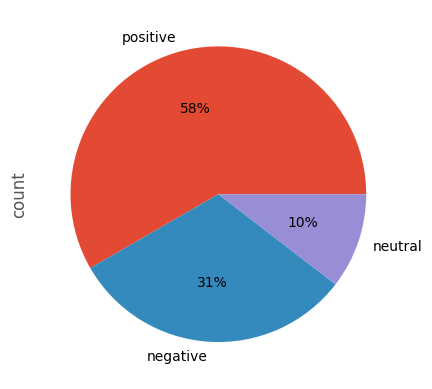

In [ ]:
plot = df.label.value_counts().plot.pie(subplots=True, autopct='%1.0f%%')
plot

In [ ]:
df.groupby('label').describe().T

label       negative                                            neutral  \
teks count      3436                                               1148   
     unique     3412                                               1138   
     top       kesal  diminta luhut stop penenggelaman kapal , begin...   
     freq          4                                                  2   

label                                                 positive  
teks count                                                6416  
     unique                                               6383  
     top     jangan pernah kecewa dengan apa yang diberikan...  
     freq                                                    4

## CLEANSING

In [ ]:
import re

def cleansing (text):
    string = text.lower()
    string = re.sub(r'[^a-zA-Z0-9]',' ', string)
    return string

In [ ]:
df['teksclean']=df.teks.apply(cleansing)
df.head()

,teks,label,teksclean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung t...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kas...


In [ ]:
neg = df.loc[df['label'] == 'negative'].teksclean.tolist()
neu = df.loc[df['label'] == 'neutral'].teksclean.tolist()
pos = df.loc[df['label'] == 'positive'].teksclean.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

In [ ]:
totaldata = neg + neu + pos
labels = neg_label + neu_label + pos_label

print("Neg: %s, Neu: %s, Pos: %s" %(len(neg), len(neu), len(pos)))
print("Total data: %s" %len(totaldata))

Neg: 3436, Neu: 1148, Pos: 6416
Total data: 11000


## FEATURE EXTRACTION

In [ ]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

In [ ]:
max_features = 10000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(totaldata)
with open ('tokenizer1.pickle','wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print ("tokenizer1.pickle has created")

X = tokenizer.texts_to_sequences(totaldata)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open ('x_pad_sequences1.pickle','wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('x_pad_sequences1.pickle has created')

tokenizer1.pickle has created
x_pad_sequences1.pickle has created


In [ ]:
Y = pd.get_dummies(labels)
Y = Y.values

with open ('y_labels1.pickle','wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('y_labels1.pickle has created')

y_labels1.pickle has created


In [ ]:
from sklearn.model_selection import train_test_split

file = open("x_pad_sequences1.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels1.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=1)

## LSTM

In [ ]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten, SpatialDropout1D, GlobalAveragePooling1D
from tensorflow.keras import backend as K
import keras

In [ ]:
embed_dim = 100
units = 128

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_shape=(X.shape[1],)))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(units, return_sequences=False))
model.add(layers.Dropout(0.2))
model.add(Dense(3,activation='softmax'))
#model.compile(loss= 'binary_crossentropy', optimizer='adam', metrics =['accuracy'])
opt = optimizers.Adam(learning_rate = 0.001)
model.compile(loss= 'categorical_crossentropy', optimizer=opt, metrics =['accuracy'])
print(model.summary())

#es = EarlyStopping (monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=15, batch_size=256, validation_data=(X_test, y_test), verbose=1)
#callbacks=[es]

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 90, 100)           1000000   
                                                                 
 spatial_dropout1d_13 (Spat  (None, 90, 100)           0         
 ialDropout1D)                                                   
                                                                 
 lstm_13 (LSTM)              (None, 128)               117248    
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 3)                 387       
                                                                 
Total params: 1117635 (4.26 MB)
Trainable params: 1117635 (4.26 MB)
Non-trainable params: 0 (0.00 Byte)
_______________

In [ ]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print ("TESTING SELESAI")
print(matrix_test)

69/69 [==============================] - 4s 48ms/step
TESTING SELESAI
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       704
           1       0.86      0.71      0.78       222
           2       0.88      0.90      0.89      1274

    accuracy                           0.85      2200
   macro avg       0.84      0.80      0.82      2200
weighted avg       0.85      0.85      0.84      2200



## CROSS VALIDATION

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=42, shuffle=True)

accuracies = []
y = Y

for iteration, data in enumerate(kf.split(X), start=1):
    data_train = X[data[0]]
    target_train = y[data[0]]

    data_test = X[data[1]]
    target_test = y[data[1]]

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_shape=(X.shape[1],)))
    model.add(LSTM(units))
    model.add(layers.Dropout(0.5))
    model.add(Dense(3,activation='softmax'))
    opt = optimizers.Adam(learning_rate = 0.001)
    model.compile(loss= 'categorical_crossentropy', optimizer=opt, metrics =['accuracy'])

    #es = EarlyStopping (monitor='val_loss', mode='min', verbose=0)
    history = model.fit(X_train, y_train, epochs=10, batch_size=1024, validation_data=(X_test, y_test), verbose=0)
    #verbose 1 menjadi 0

    predictions = model.predict(X_test)
    y_pred = predictions

    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    #metrics report menjadi accuracy score

    print ('Training ke-', iteration)
    print (classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print ('===================================================================')

    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)

print()
print()
print()
print('Rata-rata Accuracy:', average_accuracy)


69/69 [==============================] - 1s 14ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.62      0.54      0.57       704
           1       0.44      0.14      0.21       222
           2       0.74      0.88      0.80      1274

    accuracy                           0.70      2200
   macro avg       0.60      0.52      0.53      2200
weighted avg       0.67      0.70      0.67      2200

69/69 [==============================] - 2s 15ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.60      0.31      0.40       704
           1       0.56      0.02      0.04       222
           2       0.63      0.90      0.74      1274

    accuracy                           0.62      2200
   macro avg       0.59      0.41      0.40      2200
weighted avg       0.61      0.62      0.56      2200

69/69 [==============================] - 1s 13ms/step
Training ke- 3
              precision    reca

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


69/69 [==============================] - 1s 13ms/step
Training ke- 5
              precision    recall  f1-score   support

           0       0.60      0.35      0.44       704
           1       0.00      0.00      0.00       222
           2       0.66      0.92      0.77      1274

    accuracy                           0.65      2200
   macro avg       0.42      0.42      0.40      2200
weighted avg       0.57      0.65      0.59      2200




Rata-rata Accuracy: 0.6459090909090909


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## MODELLING

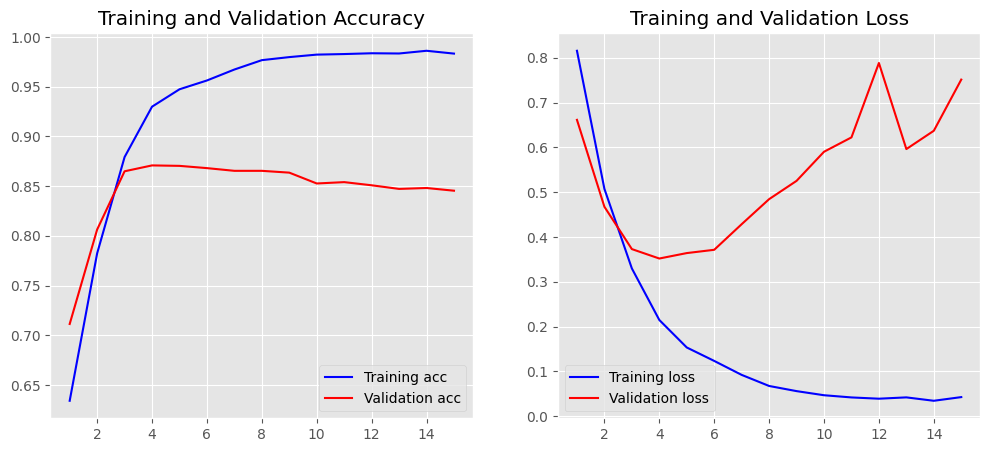

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plothist (history):
    acc = history.history ['accuracy']
    val_acc = history.history ['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) +1)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title ('Training and Validation Accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title ('Training and Validation Loss')
    plt.legend()

%matplotlib inline
plothist (history)


In [ ]:
model.save('model-lstm.h5')
print ('Model has created')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model has created


## PREDICT

In [ ]:
from keras.models import load_model

input_text = """
Rasa syukur, cukup.
"""

def cleansing (input):
    string = input.lower()
    string = re.sub(r'[^a-zA-Z0-9]',' ', string)
    return string

sentiment = ['negative','neutral','positive']

teks = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(teks)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model-lstm.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print('Teks: ', teks[0])
print('Sentiment: ', sentiment[polarity])

1/1 [==============================] - 1s 750ms/step
Teks:   rasa syukur  cukup  
Sentiment:  positive


array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    34, 11021,    25]], dtype=int32)

In [ ]:
polarity

0